## Neural Art Demo
Based on research ([A Neural Algorithm of Artistic Style](http://arxiv.org/abs/1508.06576)) by Leon A. Gatys, Alexander S. Ecker, and Matthias Bethge.  
<font size=2pt color=gray>
Modified from [original](https://github.com/apache/incubator-mxnet/blob/master/example/neural-style/neuralart.ipynb).
</font>


Button(description='Content', style=ButtonStyle())

Button(description='Style', style=ButtonStyle())

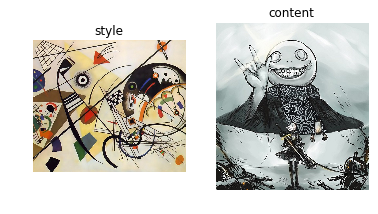

In [7]:
# some setup
%matplotlib inline
import matplotlib.pyplot as plt
import os
import urllib.request as urllib
import numpy as np
from skimage import io

import logging
logging.basicConfig(level=logging.CRITICAL)  # disable the verbose INFO messages for cleaner notebook display
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

from PyQt5.QtWidgets import (QMainWindow, QTextEdit, QAction, QFileDialog, QApplication)
from PyQt5.QtGui import QIcon
import sys

import nstyle  # Load code for neural style training

def openfile_dialog():
    app = QApplication([])
    #fname = QFileDialog.getOpenFileName(None, 'Open file', '/home')
    #fname = QtGui.QFileDialog.getOpenFileName(None, "Select a file...", '.', filter="All files (*)")
    fname = QFileDialog.getOpenFileName(None, 'Open file', './input', "Image Files (*.png *.jpg *.bmp)")
    #fileName = QFileDialog.getOpenFileName(this, tr("Open Image"), "/home/jana", tr("Image Files (*.png *.jpg *.bmp)"));
    #return str(fname[0])
    return os.path.relpath(str(fname[0]), start=os.curdir)

def ensure_dir(path):
    """Makes sure the path exists so we can save a file to it."""
    dirname = os.path.dirname(path)
    try:
        os.mkdir(dirname)
    except OSError:
        # Probably because the path exists already
        pass

# Download the CNN
cnn_path = 'model/vgg19.params'
if not os.path.isfile(cnn_path):
    cnn_url = "https://github.com/dmlc/web-data/raw/master/mxnet/neural-style/model/vgg19.params"
    ensure_dir(cnn_path)
    urllib.urlretrieve(cnn_url, cnn_path)


#Check for input files
%store -r
try:
    ensure_dir(style_path)
except NameError:
    style_path = "input/style.jpg"
    ensure_dir(style_path)
try:
    ensure_dir(content_path)
except NameError:
    content_path = "input/content.jpg"
    ensure_dir(content_path)
    
# Download the images   
# urllib.urlretrieve(style_url, style_path)
# urllib.urlretrieve(content_url, content_path)
# URL to the style image. Change this to use your own style.
#style_url = """https://github.com/dmlc/web-data/raw/master/mxnet/neural-style/input/starry_night.jpg"""
# URL to the content image. Change this to use your own content
#content_url = """https://github.com/dmlc/web-data/raw/master/mxnet/neural-style/input/IMG_4343.jpg"""

style_img = io.imread(style_path)
content_img = io.imread(content_path)

def drawImgs():
    plt.subplot(121)
    plt.axis('off')
    plt.title('style')
    plt.imshow(style_img)
    plt.subplot(122)
    plt.axis('off')
    plt.title('content')
    plt.imshow(content_img)
    plt.show()

from IPython.display import clear_output
def redrawImgs():
    clear_output(wait=True)
    display(buttonC)
    display(buttonS)
    plt.close()
    drawImgs()
    

import ipywidgets as widgets
from IPython.display import display

buttonC = widgets.Button(description="Content")
display(buttonC)
buttonS = widgets.Button(description="Style")
display(buttonS)

def on_buttonC_clicked(c):
    global content_path
    try: 
        content_path = openfile_dialog()
    except ValueError:
        pass
    %store content_path
    global content_img
    content_img = io.imread(content_path)
    redrawImgs()

buttonC.on_click(on_buttonC_clicked)

def on_buttonS_clicked(s):
    global style_path
    try:
        style_path = openfile_dialog()
    except ValueError:
        pass
    %store style_path
    global style_img
    style_img = io.imread(style_path)
    redrawImgs()

buttonS.on_click(on_buttonS_clicked)

# Show the images
    
drawImgs()


### Set parameters

In [2]:
#import nstyle  # Load code for neural style training
args = nstyle.get_args([])  # get the defaults args object

# Stopping criterion. A larger value means less time but lower quality.
# 0.01 to 0.001 is a decent range. 
args.stop_eps = 0.001

# Resize the long edge of the input images to this size.
# Smaller value is faster but the result will have lower resolution.
args.max_long_edge = 500

# content image weight. A larger value means more original content.
args.content_weight = 12.0

# Style image weight. A larger value means more style.
args.style_weight = 1.0

# Initial learning rate. Changing this affects the result. Default 0.001
args.lr = 0.0019

# Learning rate schedule.  How often to decrease and by how much
args.lr_sched_delay = 19
args.lr_sched_factor = 0.94

# How often to update the notebook display
args.save_epochs = 40

# How long to run for
args.max_num_epochs = 2000

# Default 0.01
args.tv_weight = 0.5

# Remove noise. The amount of noise to remove. Default 0.02.
args.remove_noise = 0.04

# Momentum, default 0.95
args.momentum = 0.95

# Weight decay, default 0.0001
args.wd = 0.0001

args.content_image = content_path
args.style_image = style_path


# Change this to 0 to use GPU with for example mxnet-cu90, will speed things up considerably.
args.gpu = -1 # -1 to use CPU, 0 to use GPU1


args.output_dir = 'output/'
ensure_dir(args.output_dir)

# Setup live learning curve chart

In [3]:
import IPython.display
import mxnet.notebook.callback
import math
import time
from datetime import timedelta

eps_chart = mxnet.notebook.callback.LiveTimeSeries(y_axis_label='log_10(eps)',
        # Setting y-axis to log-scale makes sense, but bokeh has a bug
        # https://github.com/bokeh/bokeh/issues/5393
        # So I'll calculate log by hand below.
        #y_axis_type='log',  
    )
def show_img(data):
    eps_chart.update_chart_data(math.log10(data['eps']))
    if data.get('filename',None):
        time.sleep(0.75)
        IPython.display.clear_output(wait=False)
        print("Epoch %d\neps = %g\nlr = %f\nTime = %s" % (data['epoch'], data['eps'], data['lr'], str(timedelta(seconds=-(start-time.time())))))
        h = IPython.display.HTML("<img src='"+data['filename']+"'>")
        print(data['filename'])
        IPython.display.display(h)

Loading BokehJS ...

## Start  
Train network and render

Epoch 880
eps = 0.00102376
lr = 0.000067
Time = 0:03:28.622930
output/e_880.png


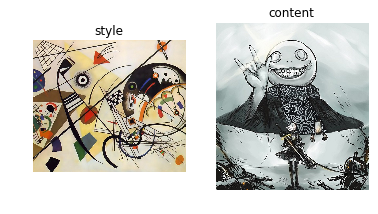

In [4]:
args.content_image = content_path
args.style_image = style_path

start = time.time()
nstyle.train_nstyle(args, callback=show_img)
end = time.time()
drawImgs()

Button(description='Content', style=ButtonStyle())

Button(description='Style', style=ButtonStyle())

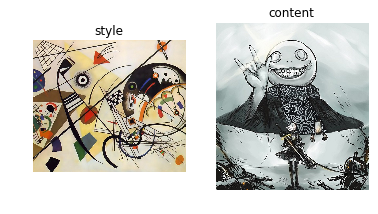

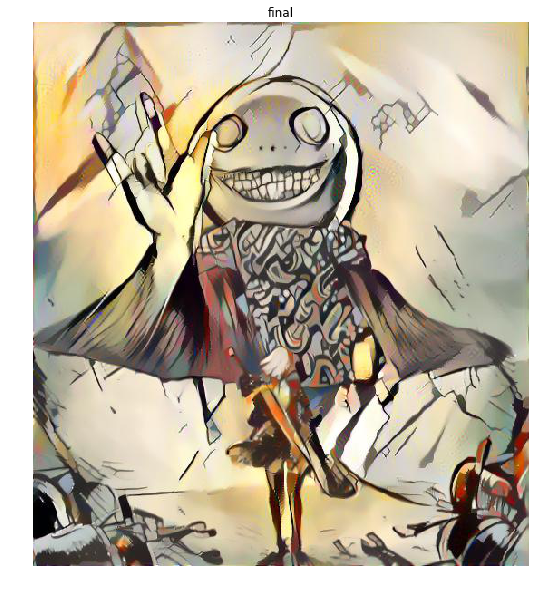

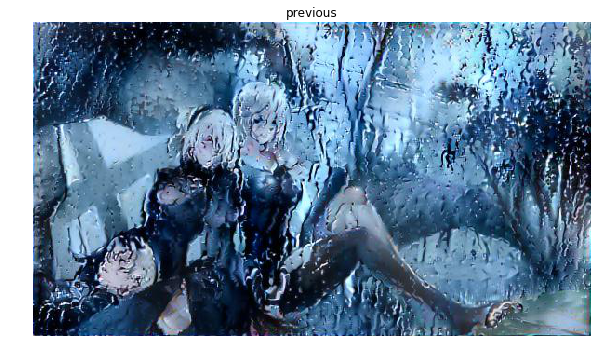

Total time: 210.29444313049316


In [6]:
display(buttonC)
display(buttonS)

drawImgs()
final_img = io.imread(args.output_dir+'final.png')

plt.figure(figsize=(10,10))
plt.axis('off')
plt.title('final')
plt.imshow(final_img)

if os.path.isfile(args.output_dir+'previous.png'):
    prev_img = io.imread(args.output_dir+'previous.png')
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.title('previous')
    plt.imshow(prev_img)

plt.show()

try:
    print("Total time: " + str(end - start))
except NameError:
    pass